In [1]:
# Dataframes.
import pandas as pd

# Numerical arrays.
import numpy as np

# Stationarity
from statsmodels.tsa.stattools import adfuller

# Predictions
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from pmdarima.arima.utils import ndiffs
from pmdarima.utils import diff_inv
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# Plotting.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline
# Change style and size of plots
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.titlesize"] = 15

# EDA

In [2]:
stores = pd.read_csv('stores.csv')
stores.head()

,Store,Type,Size,Store A,Store B,Store C
0,1,A,151315,219622.0000,140167.0000,42988.00000
1,2,A,202307,39690.0000,34875.0000,39690.00000
2,4,A,205863,177247.7273,101190.7059,40541.66667
3,6,A,202505,NaN,NaN,NaN
4,8,A,155078,NaN,NaN,NaN


In [3]:
stores.tail()


,Store,Type,Size,Store A,Store B,Store C
40,37,C,39910,NaN,NaN,NaN
41,38,C,39690,NaN,NaN,NaN
42,42,C,39690,NaN,NaN,NaN
43,43,C,41062,NaN,NaN,NaN
44,44,C,39910,NaN,NaN,NaN


In [4]:
stores.describe()

,Store,Size,Store A,Store B,Store C
count,45.000000,45.000000,3.000000,3.000000,3.000000
mean,23.000000,130287.600000,145519.909100,92077.568633,41073.222223
std,13.133926,63825.271991,94068.443124,53234.277201,1712.049789
min,1.000000,34875.000000,39690.000000,34875.000000,39690.000000
25%,12.000000,70713.000000,108468.863650,68032.852950,40115.833335
50%,23.000000,126512.000000,177247.727300,101190.705900,40541.666670
75%,34.000000,202307.000000,198434.863650,120678.852950,41764.833335
max,45.000000,219622.000000,219622.000000,140167.000000,42988.000000


The stores file consist of information about 45 stores, including the type and size of each. We can observe that there are mainly empty values in the columns Store A, Store B and Store C.


2. Data cleaning.

The first step to cleansing the data is by checking it for empty values.

In [5]:
stores.isnull().sum()

Store       0
Type        0
Size        0
Store A    42
Store B    42
Store C    42
dtype: int64

The above confirms that only the last three columns have the empty values. Since they do not provide enough information that could be valuable in the sales forecasting, they will be removed.

In [6]:
# Remove columns with empty values.
cleaned_stores = stores.drop(['Store A','Store B','Store C'], axis=1)

# Check for empty values again.
cleaned_stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

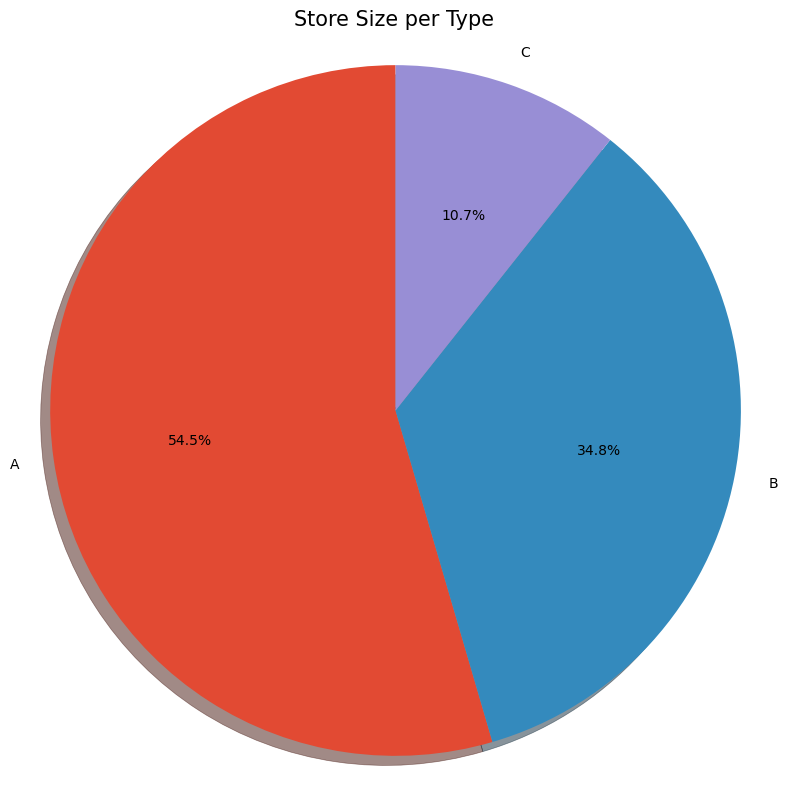

In [7]:
# Calculate maximum values of each store type and set as pie sizes
sizes = cleaned_stores.groupby('Type').max().Size.values
labels = cleaned_stores.groupby('Type').max().index

# Create a figure and axis, set a title.
fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle("Store Size per Type")

# Build a pie plot.
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal') 

# Show the plot.
plt.tight_layout()
plt.show()

# Train.

In [8]:
train = pd.read_csv('train.csv', header=0, parse_dates=True, index_col="Date")
train.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [9]:
train.tail()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2012-09-28,45,98,508.37,False
2012-10-05,45,98,628.10,False
2012-10-12,45,98,1061.02,False
2012-10-19,45,98,760.01,False
2012-10-26,45,98,1076.80,False


In [10]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


The above dataframe contains weekly sales for 45 stores per department for the period from 2010-02-05 to 2012-10-26. We can see that altogether there are 99 departments. It also includes the department number and whether the week is a special holiday week.

In [11]:
train.isnull().sum()


Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [12]:
depts = train.groupby("Store").Dept.nunique()
print(f"Maximum Departments: {np.max(depts)}\nMinimum Departments: {np.min(depts)}")

Maximum Departments: 79
Minimum Departments: 61


It is clear that the stores have different distribution of departments.

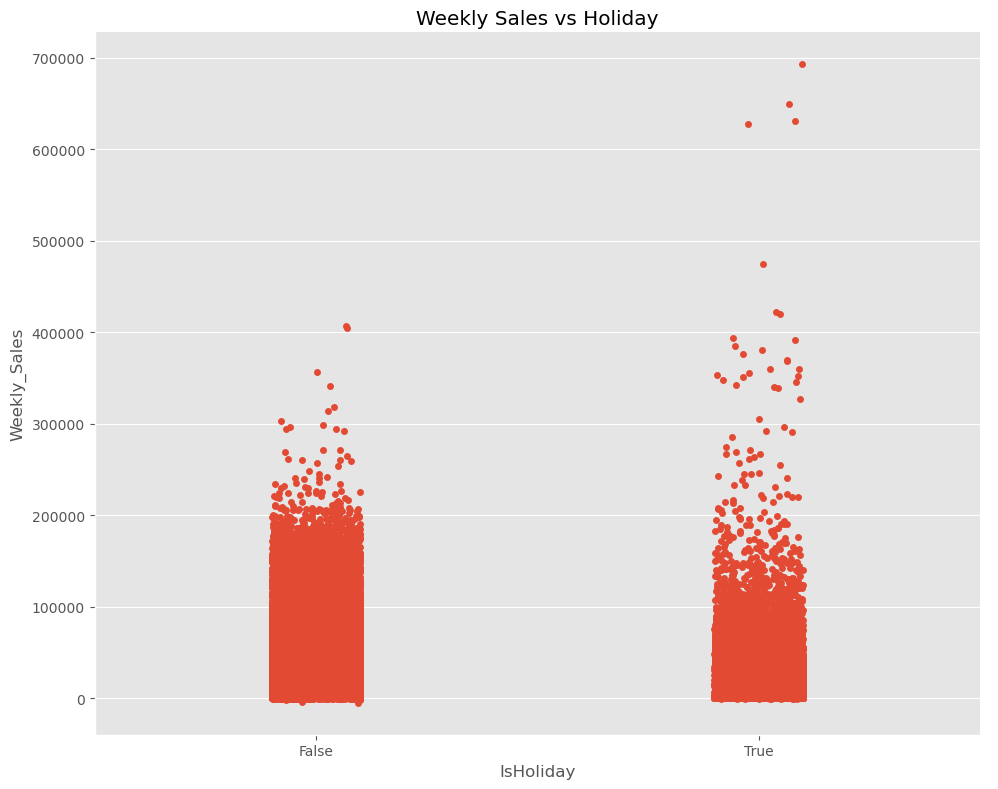

In [13]:
# Plot the data by year
g = sns.catplot(x='IsHoliday', y='Weekly_Sales', data=train)
g.fig.set_size_inches(10,8)

# Show the plot.
plt.title("Weekly Sales vs Holiday")
plt.tight_layout()
plt.show()

# Features.

In [14]:
# Load the features.csv without an index.
features = pd.read_csv("features.csv", header=0, parse_dates=True, index_col="Date")

# Display the dafaframe
features.head()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2010-02-05,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2010-02-12,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2010-02-19,1,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
2010-02-26,1,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
2010-03-05,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [15]:
features.tail()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2013-06-28,45,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
2013-07-05,45,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
2013-07-12,45,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
2013-07-19,45,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
2013-07-26,45,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


The features file contains additional data related to the store, department, and regional activity for the given dates. MarkDown columns are related to promotional markdowns that Walmart is running.

In [16]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [17]:
features.isnull().sum()

Store              0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [18]:
# Ensure the index is sorted
features = features.sort_index()

# Use the correct date format for slicing
subset = features.loc['2011-11-01':'2011-11-30']


In [19]:
features = features.loc['2011-11-11': '2013-07-26']
features

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2011-11-11,39,63.11,3.297,8894.84,10678.05,342.83,2414.95,10590.23,216.721737,7.716,False
2011-11-11,6,61.33,3.297,12590.41,2173.66,123.20,3108.55,5416.96,219.563113,6.551,False
2011-11-11,7,19.53,3.505,3307.60,1431.65,143.06,1330.31,1680.90,195.637694,8.513,False
2011-11-11,37,63.50,3.297,8.62,56.53,117.92,NaN,796.28,216.721737,7.716,False
2011-11-11,19,48.22,3.719,27064.58,16590.75,502.96,8568.62,6349.89,136.461806,7.866,False
...,...,...,...,...,...,...,...,...,...,...,...
2013-07-26,32,72.99,3.582,549.89,940.93,86.00,106.47,1530.56,NaN,NaN,False
2013-07-26,13,83.62,3.669,346.31,1377.41,93.40,140.32,2147.06,NaN,NaN,False
2013-07-26,31,85.00,3.620,1394.82,138.71,12.00,970.77,6859.07,NaN,NaN,False


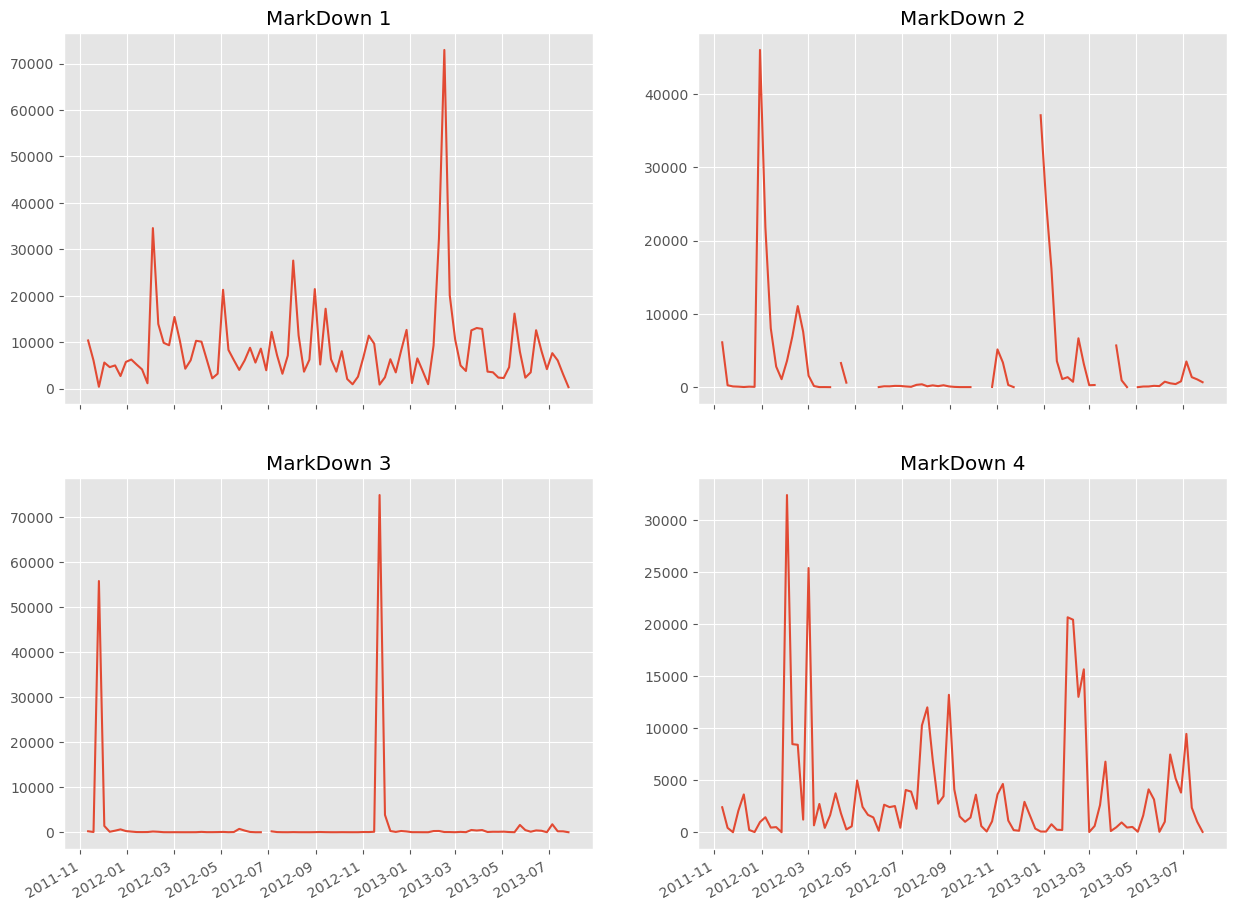

In [20]:
def date_format(ax, int):
    # Make the x axis display well.
    weeks = mdates.DayLocator(int)
    h_fmt = mdates.DateFormatter('%d-%m-%Y')

    # Tick ax axis.
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(h_fmt)
# Calculate mean of columns in features.
temp = features[features["Store"]==1].groupby(["Date"]).mean()

# Create a figure and a set of axis
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(15,12))

# Date Format.
fig.autofmt_xdate()

# Plot the data.
ax1.plot(temp.MarkDown1)
ax1.title.set_text("MarkDown 1")
ax2.plot(temp.MarkDown2)
ax2.title.set_text("MarkDown 2")
ax3.plot(temp.MarkDown3)
ax3.title.set_text("MarkDown 3")
ax4.plot(temp.MarkDown4)
ax4.title.set_text("MarkDown 4")

# Show the plots.
plt.show()

fill the missing data

In [21]:
features["MarkDown1"].fillna(method="ffill", inplace=True)
features["MarkDown2"].fillna(method="ffill", inplace=True)
features["MarkDown3"].fillna(method="bfill", inplace=True)
features["MarkDown4"].fillna(method="ffill", inplace=True)

C:\Users\keith\AppData\Local\Temp\ipykernel_3940\55285462.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features["MarkDown1"].fillna(method="ffill", inplace=True)
C:\Users\keith\AppData\Local\Temp\ipykernel_3940\55285462.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features["MarkDown1"].fillna(method="ffill", inplace=True)
C:\Users\keith\AppData\Local\Temp\ipykernel_3940\55285462.py:2: FutureWarning: A value is trying to be se

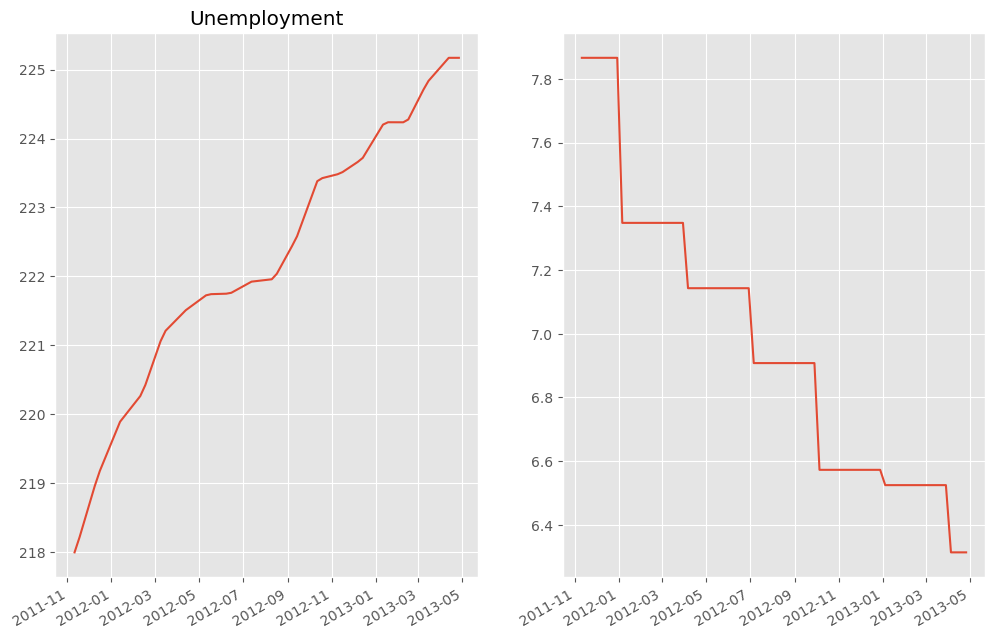

In [22]:
# Create a figure and a set of axis
fig, [ax1,ax2] = plt.subplots(1,2)

# Date Format.
fig.autofmt_xdate()

# Plot the data.
ax1.plot(temp.CPI)
ax1.title.set_text("CPI")
ax2.plot(temp.Unemployment)
ax1.title.set_text("Unemployment")

# Show the plots.
plt.show()

In [23]:
# Filling missing values for CPI and unemployment
features["CPI"].fillna(method="ffill", inplace=True)
features["Unemployment"].fillna(method="ffill", inplace=True)
# Checking for missing values again.
features.isnull().sum()

C:\Users\keith\AppData\Local\Temp\ipykernel_3940\823135802.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features["CPI"].fillna(method="ffill", inplace=True)
C:\Users\keith\AppData\Local\Temp\ipykernel_3940\823135802.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features["CPI"].fillna(method="ffill", inplace=True)
C:\Users\keith\AppData\Local\Temp\ipykernel_3940\823135802.py:3: FutureWarning: A value is trying to be set on a co

Store           0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

In [24]:
features_train = features.loc['2011-11-11': '2012-10-26'].reset_index()
features_test = features.loc['2012-11-02': '2013-07-26'].reset_index()
features_train.head()

,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,2011-11-11,39,63.11,3.297,8894.84,10678.05,342.83,2414.95,10590.23,216.721737,7.716,False
1,2011-11-11,6,61.33,3.297,12590.41,2173.66,123.20,3108.55,5416.96,219.563113,6.551,False
2,2011-11-11,7,19.53,3.505,3307.60,1431.65,143.06,1330.31,1680.90,195.637694,8.513,False
3,2011-11-11,37,63.50,3.297,8.62,56.53,117.92,1330.31,796.28,216.721737,7.716,False
4,2011-11-11,19,48.22,3.719,27064.58,16590.75,502.96,8568.62,6349.89,136.461806,7.866,False


merging datasets

In [25]:
# Merge the dataframes into one.
df = train.merge(features_train, on=['Store', 'IsHoliday', 'Date'],how='left').dropna()
df = df.merge(cleaned_stores, on=['Store'], how='left')

# Timedelta
#df['Date'] = df['Date'] + pd.to_timedelta(df.groupby('Date').cumcount(), unit='m')
df=df.set_index(['Date'])

# Display the new dataframe with a date index.
df

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,,
2011-11-11,1,1,18689.54,False,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315
2011-11-18,1,1,19050.66,False,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,A,151315
2011-11-25,1,1,20911.25,True,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,218.467621,7.866,A,151315
2011-12-02,1,1,25293.49,False,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,218.714733,7.866,A,151315
2011-12-09,1,1,33305.92,False,43.93,3.158,4640.65,19.00,105.02,3639.42,14461.82,218.961846,7.866,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,45,98,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
2012-10-05,45,98,628.10,False,64.89,3.985,5046.74,38.19,18.82,2253.43,2340.01,192.170412,8.667,B,118221
2012-10-12,45,98,1061.02,False,54.47,4.000,1956.28,38.19,7.89,599.32,3990.54,192.327265,8.667,B,118221


In [26]:
df.index.duplicated().sum()

151381

In [27]:
df.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

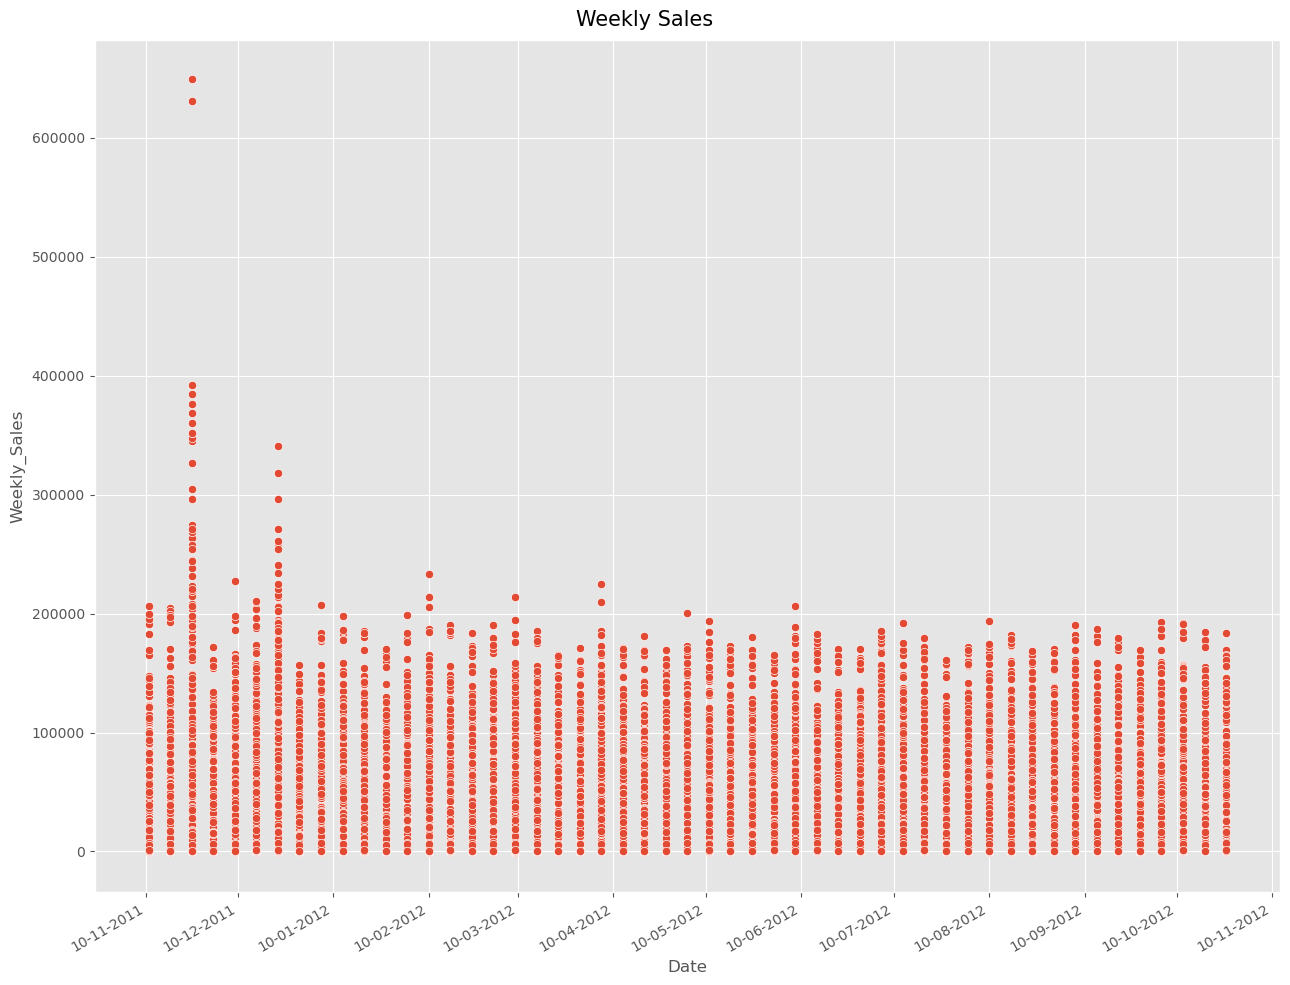

In [28]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13,10))
fig.suptitle("Weekly Sales")

# Date formatter.
date_format(ax,10)
fig.autofmt_xdate()

# Plot the sales
sns.scatterplot(data=df, x=df.index, y="Weekly_Sales", ax=ax)

# Show the plot.
plt.tight_layout()
plt.show()

# holidays and markdowns 

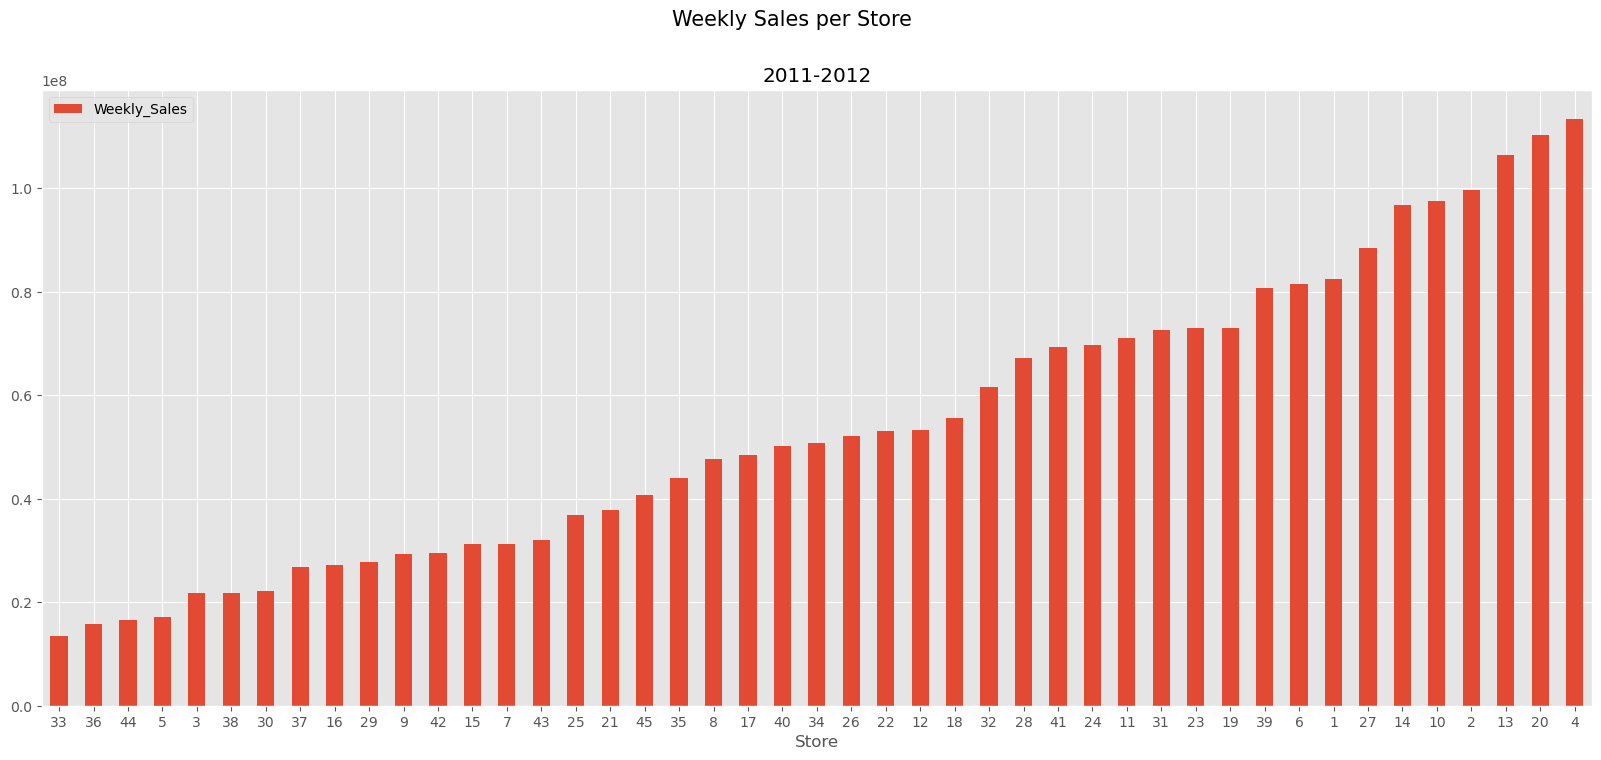

In [31]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(20,8))
fig.suptitle("Weekly Sales per Store")

# Plot the data by year
per_store = df.groupby("Store").agg({"Weekly_Sales": "sum"})
per_store.sort_values("Weekly_Sales").plot.bar(ax=ax)

# Set a title and change rotation of xticks back to 0 
plt.title("2011-2012")
plt.xticks(rotation=0)

# Show the plot.
plt.show()